Scrape information from CPAP Website

In [236]:
# Define the urls and check to see that the status code is '200'

import requests

urls = ['https://lofta.com/collections/cpap-machines','https://lofta.com/collections/cpap-masks', 'https://lofta.com/collections/supplies', 'https://lofta.com/collections/cpap-power-solutions',
        'https://lofta.com/collections/cpap-cleaning-products', 'https://lofta.com/collections/sleepsmart']
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

for url in urls:
    response = requests.get(url, headers = headers)
    print(response.status_code) 

200
200
200
200
200
200


In [237]:
# Create and append to lists by scraping through each URL

from bs4 import BeautifulSoup
import time
import datetime
import smtplib

# Create lists for variables: products, prices, brands, and product types
product_results = []
prices_results = []
brands_results = []
product_type_results = []

# For each website, iterate through these variables and append to the lists (https://stackoverflow.com/questions/40629457/scrape-multiple-urls-using-beautiful-soup)
for url in urls:
    response = requests.get(url, headers = headers)
    soup = BeautifulSoup(response.content, "html.parser")

    # use soup.find_all to grab information through html
    products = [product.string.strip() for product in soup.find_all(class_="text-lg lg:text-xlplus text-dark-blue lg:font-medium leading-tight tracking-normal")]
    prices = [price.string.strip()[1:] for price in soup.find_all(class_='text-xl font-medium font-calibre text-dark-blue-tint-10 tracking-normal')]
    brands = [brand.string.strip() for brand in soup.find_all(class_='text-sm lg:text-base text-dark-gray font-light tracking-normal mb-1 inline pr-2')]
 
    # merge all outputs into one list using append (https://stackoverflow.com/questions/71237495/how-to-merge-all-of-the-output-lists-into-one-list)
    for product in products:
        product = product.replace('™','') #clean up the product column
        product_results.append(product)
        product_type_results.append(url.split('/')[4]) #append portion of each url to the product_type_results list

    for price in prices:
        prices_results.append(price)

    for brand in brands:
        brands_results.append(brand)


In [3]:
# Create a dataframe with these lists, clean up columns, create new 'weights' column, then create a dictionary from the dataframe

import pandas as pd
import numpy as np

# Create pandas dataframe with lists
df = pd.DataFrame(list(zip(product_results, prices_results, brands_results, product_type_results)), columns = ['Product','Price','Brand','Product Type'])

# Clean up 'Product Type' column in dataframe using a dictionary
product_clean_dict = {
    'cpap-machines': 'CPAP Machine',
    'cpap-masks': 'CPAP Mask',
    'supplies': 'Supplies',
    'cpap-power-solutions': 'Power Solutions',
    'cpap-cleaning-products': 'Cleaning Products',
    'sleepsmart': 'Miscellaneous'
}
df['Product Type'] = df['Product Type'].replace(product_clean_dict, regex=True)

# Clean 'Price' column and change datatype - https://stackoverflow.com/questions/64417729/pandas-convert-numbers-with-a-comma-instead-of-the-point-for-the-decimal-separat
df['Price'] = pd.to_numeric(df['Price'].str.replace(',',''))  #convert column to float and replace commas with nothing

# Create new 'Weights'' column based on conditions of price column
conditions = [
    (df['Price'] < 10),
    (df['Price'] > 10) & (df['Price'] <=35),
    (df['Price'] > 35) & (df['Price'] <=70),
    (df['Price'] > 70) & (df['Price'] <=125),
    (df['Price'] > 125) & (df['Price'] <=200),
    (df['Price'] > 200) & (df['Price'] <=400),
    (df['Price'] > 400) & (df['Price'] <=800),
    (df['Price'] > 800) & (df['Price'] <=1400),
    (df['Price'] > 1400) & (df['Price'] <=2000)
]
values = ['30','22','16', '13', '10', '8', '6', '5', '3']

df['Weights'] = np.select(conditions, values)
df['Weights'] = pd.to_numeric(df['Weights']) #convert column to to int

# create a dictionary from this dataframe with product as the key and other columns as values - https://stackoverflow.com/questions/66149627/pandas-create-dict-where-one-column-is-key-and-list-of-remaining-columns-are-va
CPAP_products = df.set_index("Product").agg(list,1).to_dict()


Generate mock data from dataframe - 24 CSVs - 24 months of data from 2022, 2023

In [238]:
# Use dictionary to generate mock data 

import numpy
import random
import datetime
import calendar

def generate_random_time(month):
    day_range = calendar.monthrange(year_value, month)[1] # given year and month, day_range gives number of days in the month
    random_day = random.randint(1, day_range) # select random day in the month
    if random.random() < 0.25:
        date=datetime.datetime(year_value, month, random_day, 12, 0) 
    elif (random.random() >= 0.5) & (random.random() < 0.6):
        date=datetime.datetime(year_value, month, random_day, 16, 0) 
    else: 
        date=datetime.datetime(year_value, month, random_day, 20, 0)

    time_offset = np.random.normal(loc=0, scale=80) # use normal distribution to generate a time_offset centered at 0 minutes with a standard deviation of 150 minutes
    final_date = date + datetime.timedelta(minutes = time_offset)

    return final_date.strftime("%m/%d/%Y %H:%M")

def generate_random_address(): 
    street_names = ['Main','2nd','1st','3rd','4th','5th','Park','6th','Oak','7th','Maple','Pine','Washington','8th','Cedar','Elm'] # (https://fivethirtyeight.com/features/whats-the-most-common-street-name-in-america/)
    cities = ['New York City','Los Angeles','Chicago','Houston','Phoenix','Philadelphia','San Antonio','San Diego','Dallas','San Jose','Columbus'] # searched most popular cities/states + columbus/OH (https://worldpopulationreview.com/us-cities)
    weights = [15, 8, 5, 5, 4, 3, 3, 3, 3, 2, 2] # used weights loosely based on population
    states = ['NY','CA','IL','TX','AZ','PA','TX','CA','TX','CA','OH'] 
    zip_code = ['10001','90080','60618','77203','85082','19092','78279','92160','75342','95101','43210'] # search most popular zip code by location on Google

    street = random.choice(street_names)
    index = random.choices(range(len(cities)), weights = weights)[0] # pass in range of length of cities list to get an index value --> use it for cities, states, zips.

    return f"{random.randint(1,999)} {street} St, {cities[index]}, {states[index]} {zip_code[index]}"

# Generate list that will be added to dataframe
def write_row(order_id, CPAP_product, order_date, address): 
    CPAP_price = CPAP_products[CPAP_product][0]
    CPAP_brand = CPAP_products[CPAP_product][1]
    CPAP_product_type = CPAP_products[CPAP_product][2]
    quantity_ordered = numpy.random.geometric(p=1.0 - (3.0/CPAP_price), size = 1)[0] # Use geometric distribution. Higher p value means quantity_ordered more likely to be 1
    return [order_id, CPAP_product, quantity_ordered, CPAP_price, date, address, CPAP_brand, CPAP_product_type]


if __name__ == "__main__": # code only runs if CPAP Scraping.ipynb used as main file
    product_list = [CPAP_product for CPAP_product in CPAP_products] # list comprehension on CPAP_products dictionary to get the key
    weights = [CPAP_products[CPAP_product][3] for CPAP_product in CPAP_products] # list comprehension to get weights on 3rd index
    columns = ['Order ID', 'Product', 'Quantity Ordered', 'Price Each', 'Order Date', 'Purchase Address', 'Brand', 'Product Type']
    order_id = 183489

    for year_value in range(2022, 2024):
        for month_value in range(1,13):
        # generate normal distribution centered around loc with a standard deviation of scale
            if month_value == 12:
                orders_amount = int(numpy.random.normal(loc=9000, scale=800))
            if month_value == 11:
                orders_amount = int(numpy.random.normal(loc=7000, scale=900))
            if month_value == 10:
                orders_amount = int(numpy.random.normal(loc=6000, scale=1000))
            if month_value == 9:
                orders_amount = int(numpy.random.normal(loc=5000, scale=1100))
            if month_value == 8:
                orders_amount = int(numpy.random.normal(loc=4000, scale=1200))
            if month_value == 7:
                orders_amount = int(numpy.random.normal(loc=5000, scale=1100))
            if month_value == 6:
                orders_amount = int(numpy.random.normal(loc=4500, scale=1150))
            if month_value == 5:
                orders_amount = int(numpy.random.normal(loc=5000, scale=1100))
            if month_value == 4:
                orders_amount = int(numpy.random.normal(loc=5500, scale=1050))
            if month_value == 3:
                orders_amount = int(numpy.random.normal(loc=6000, scale=1000))
            if month_value == 2:
                orders_amount = int(numpy.random.normal(loc=7000, scale=900))
            if month_value == 1:
                orders_amount = int(numpy.random.normal(loc=8000, scale=850))

            CPAP_df = pd.DataFrame(columns = columns)
            
            i=0
            while orders_amount > 0: # use while loop because the number of rows may increase if items are sold together. Ex. in Dec 2022 orders_amount is randomly assigned 9022, we will generate 9022 orders, with each order decreasing the orders_amount by 1 until it reaches 0. i is the number of rows, orders_amount is number of orders
                address = generate_random_address()
                date = generate_random_time(month_value)

                CPAP_product = random.choices(product_list, weights=weights)[0] # random.choices returns a list, so pass in [0]
                CPAP_df.loc[i] = write_row(order_id, CPAP_product, date, address) # quantity ordered, price, brand, and product type already figured out in the write_row function
                i += 1

                # add items likely to be sold together
                if CPAP_product=='AirSense 11 AutoSet CPAP Machine':
                    if random.random() < 0.30:
                        CPAP_df.loc[i] = write_row(order_id, "AirFit N20 Nasal Cushion CPAP Mask Complete System", date, address)
                        i = i+1
                    if random.random() < 0.40:
                        CPAP_df.loc[i] = write_row(order_id, "Filter Cover for AirSense 10", date, address)
                        i = i+1
                    if random.random() < 0.15:
                        CPAP_df.loc[i] = write_row(order_id, "Resmed AirSense 11 Power Supply - 65W", date, address)
                        i = i+1
                if CPAP_product == 'AirSense 10 AutoSet Card-to-Cloud CPAP Machine':
                    if random.random() < 0.25:
                        CPAP_df.loc[i] = write_row(order_id, "AirFit N30i Nasal Cradle CPAP Mask - Complete Starter Kit", date, address)
                        i = i+1
                    if random.random() < 0.40:
                        CPAP_df.loc[i] = write_row(order_id, "Lofta Disposable Filters for AirSense 10 and AirCurve 10", date, address)
                        i = i+1
                    if random.random() < 0.25:
                        CPAP_df.loc[i] = write_row(order_id, "AirCurve and AirSense 10 Slim Tubing by Lofta", date, address)
                        i = i+1
                if CPAP_product == 'AirMini - AutoSet Travel Portable CPAP Machine':
                    if random.random() < 0.50:
                        CPAP_df.loc[i] = write_row(order_id, "Lofta Travel CPAP Disposable Air Filters for AirMini", date, address)
                        i = i+1
                    if random.random() < 0.25:
                        CPAP_df.loc[i] = write_row(order_id, "AirMini Travel CPAP Setup Pack for AirFit F20 Full Mask", date, address)
                        i = i+1
                    if random.random() < 0.40:
                        CPAP_df.loc[i] = write_row(order_id, "AirFit F20 Full Face CPAP Mask - Complete System with Airmini Setup Pack", date, address)
                        i = i+1
                if CPAP_product == 'Breas Z2 Auto Travel CPAP Machine':
                    if random.random() < 0.15:
                        CPAP_df.loc[i] = write_row(order_id, "Heat/Moisture Exchanger (HME)", date, address)
                        i = i+1
                    if random.random() < 0.25:
                        CPAP_df.loc[i] = write_row(order_id, "Breas Slim Style Tube", date, address)
                        i = i+1
                    if random.random() < 0.10:
                        CPAP_df.loc[i] = write_row(order_id, "Z1 and Z2 Power Supply", date, address)
                        i = i+1
                if CPAP_product == 'AirCurve 10 VAuto BiLevel CPAP Machine':
                    if random.random() < 0.15:
                        CPAP_df.loc[i] = write_row(order_id, "AirFit N20 for Her Nasal Cushion CPAP Mask Complete System", date, address)
                        i = i+1
                    if random.random() < 0.30:
                        CPAP_df.loc[i] = write_row(order_id, "AirFit N20 Nasal CPAP Mask Frame & Cushion", date, address)
                        i = i+1
                    if random.random() < 0.25:
                        CPAP_df.loc[i] = write_row(order_id, "AirCurve and AirSense 10 Slim Tubing by Lofta", date, address)
                        i = i+1
                if CPAP_product == 'Luna G3 BiLevel 25A CPAP Machine':
                    if random.random() < 0.50:
                        CPAP_df.loc[i] = write_row(order_id, "Luna G3 Reusable Air Filter - 2 Pack", date, address)
                        i = i+1
                    if random.random() < 0.20:
                        CPAP_df.loc[i] = write_row(order_id, "Luna G3 Replacement Water Chamber", date, address)
                        i = i+1
                    if random.random() < 0.05:
                        CPAP_df.loc[i] = write_row(order_id, "Luna G3 Power Supply Power Adapter", date, address)
                        i = i+1
                
                if random.random() <= 0.12: #12% chance of random products being ordered together
                    CPAP_product2 = random.choices(product_list, weights=weights)[0]
                    CPAP_df.loc[i] = write_row(order_id, CPAP_product2, date, address)
                    i +=1

                order_id +=1 # each time we run through the loop (finish an order), update order_id to be one more
                orders_amount -= 1 # each time we finish an order, we decrease orders_amount by 1
            
            month_name = calendar.month_name[month_value]
            print(month_name + ' ' + str(year_value) + " processed")
            CPAP_df.to_csv(f"{month_name}_{year_value}_data.csv", index=False)

January 2022 processed
February 2022 processed
March 2022 processed
April 2022 processed
May 2022 processed
June 2022 processed
July 2022 processed
August 2022 processed
September 2022 processed
October 2022 processed
November 2022 processed
December 2022 processed
January 2023 processed
February 2023 processed
March 2023 processed
April 2023 processed
May 2023 processed
June 2023 processed
July 2023 processed
August 2023 processed
September 2023 processed
October 2023 processed
November 2023 processed
December 2023 processed


Analyze and visualize the data

In [248]:
# Merge the 24 CSVs into a single CSV & dataframe

import os
import pandas as pd

dir_path = r'C:\Users\dusti\Documents\Data Analysis\Python\Projects'
merged_file = 'all_data.csv'
final_file = 'final_data.csv'
files = []

# Check if merged and final files already exists and then delete before creating
data_file_path = os.path.join(dir_path, merged_file)
final_file_path = os.path.join(dir_path, final_file)
if os.path.exists('all_data.csv'):
        os.remove(data_file_path)
        os.remove(final_file_path)

# Get a list comprehension of all the 24 CSVs
for path in os.listdir(dir_path):
        if ".csv" in path:
                files.append(path)

# Define empty dataframe to store data
all_data = pd.DataFrame()

for file in files:
        temp_df = pd.read_csv(r"C:\Users\dusti\Documents\Data Analysis\Python\Projects\\" + file) # read all the CSVs as dataframes
        all_data = pd.concat([all_data, temp_df]) # append these to the all_data dataframe

# convert dataframe into a single CSV
all_data.to_csv("all_data.csv", index=False) 

In [251]:
# Clean and organize dataframe - setting OrderDate column as index

import pandas as pd
import numpy as np

# Remove rows where Order date is the year 2024
all_data = all_data[all_data['Order Date'].astype(str).str[6:10] != '2024']

# Change column name and convert to datetime
all_data['OrderDate'] = pd.to_datetime(all_data['Order Date']) 

# Set index of all_data to 'OrderDate'
if all_data.index.name != 'OrderDate':
    all_data.set_index('OrderDate', inplace = True)


In [252]:
# Clean and organize dataframe - adding columns and creating final CSV

# Add a year column
all_data['Year'] = all_data['OrderDate'].dt.year

# Add a month column
all_data['Month'] = all_data['OrderDate'].dt.month

# Add an hour column
all_data['Hour'] = all_data['OrderDate'].dt.hour

# Add a sales column
all_data['Sales'] = all_data['Quantity Ordered'] * all_data['Price Each']

# Create city column
cities =  all_data['Purchase Address'].str.split(',', expand = True)
all_data['City'] = cities[1]

# convert dataframe to CSV with the added columns and changes for further visualizations in Tableau
all_data.to_csv("final_data.csv", index=False)

C:\Users\dusti\AppData\Local\Temp\ipykernel_28864\2777728825.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(sales_plot.index.to_period('Y')) # Set x-axis tick labels as months


Text(0, 0.5, 'Monthly Sales')

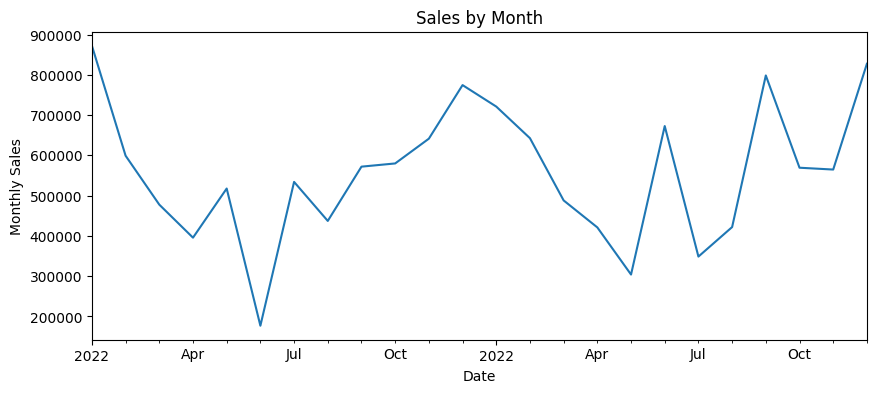

In [253]:
# 1. Determine the sales by month

import matplotlib.pyplot as plt
from calendar import month_name as mn

# Find the sum of sales by month using resample
sales_plot = all_data['Sales'].resample('M').sum()

# Visualize this (https://stackoverflow.com/questions/47298022/fixing-date-labels-when-plotting-bar-chart-of-resampled-pandas-time-series-data)
fig, ax = plt.subplots(figsize=(10,4)) # create an empty plot, separating figure and axis
sales_plot.plot(kind='line', title = 'Sales by Month') # use line plot
ax.xaxis.set_ticklabels(sales_plot.index.to_period('Y')) # Set x-axis tick labels as months
plt.ticklabel_format(style='plain', useOffset=False, axis='y') # Remove scientific notation on y axis
plt.xlabel('Date') # plot Date as x axis
plt.ylabel('Monthly Sales') # plot Monthly Sales as y axis

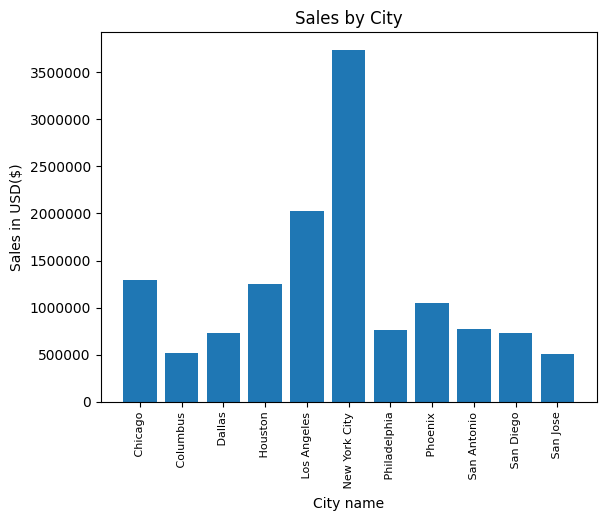

In [254]:
# 2. Determine which city had the most sales

city_sales = all_data.groupby('City')['Sales'].sum()

# Plot sales grouped by city
cities = [city for city, df in all_data.groupby('City')]

plt.bar(cities, city_sales)
plt.xticks(cities, rotation = 'vertical',size = 8)
plt.ticklabel_format(style='plain', useOffset=False, axis='y') #disables scientific notation on y-axis
plt.ylabel('Sales in USD($)')
plt.xlabel('City name')
plt.title('Sales by City')
plt.show()

In [255]:
# 3. Determine if there were more sales during the winter (Dec 21 - Mar 19) or summer (June 21 - Sept 23) (https://www.youtube.com/watch?v=UFuo7EHI8zc&t=1918s)

winter_filt = (all_data['OrderDate'] <= pd.to_datetime('2022-03-19')) + ((all_data['OrderDate'] >= pd.to_datetime('2022-12-21')) & (all_data['OrderDate'] <= pd.to_datetime('2023-03-19'))) + (all_data['OrderDate'] >= pd.to_datetime('2023-12-21'))
print('Winter Sales:' + ' $' + str(round(all_data.loc[winter_filt]['Sales'].sum(),3)))

summer_filt = ((all_data['OrderDate'] >= pd.to_datetime('2022-06-21')) & (all_data['OrderDate'] <= pd.to_datetime('2022-09-23'))) + ((all_data['OrderDate'] >= pd.to_datetime('2023-06-21')) & (all_data['OrderDate'] <= pd.to_datetime('2023-09-23')))
print('Summer Sales:' + ' $' + str(all_data.loc[summer_filt]['Sales'].sum()))

Winter Sales: $3978271.86
Summer Sales: $3023500.04


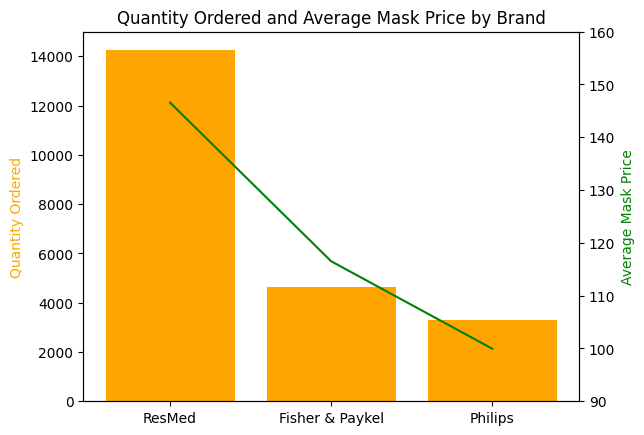

In [245]:
# 4. Based on the CPAP mask products, determine what brand was most popular by quantity ordered and compare this to the average price by brand

# Define a new dataframe where the product type is a CPAP Mask, excluding the brand 'RemZzzs'
mask_data = all_data.loc[(all_data['Product Type'] == 'CPAP Mask') & (all_data['Brand'] != 'RemZzzs')]

# create a list copmrehension for the brands 
brands = [brand for brand, df in mask_data.groupby('Brand')]

brand_quantity = mask_data.groupby('Brand')['Quantity Ordered'].sum() # Find total amount of quantity ordered masks grouped by brand
brands_qty = [brand for brand in brand_quantity] # create a list comprehension for quantity ordered grouped by brands

brand_avgprice = mask_data.groupby('Brand')['Sales'].mean() # Find average price of mask grouped by brand
brands_price = [brand for brand in brand_avgprice] # create a list comprehension for sales grouped by brands

# create a dataframe using lists then sort by quantity ordered (there might be easier way to sort out there which avoids having to create a new DF)
mask_df = pd.DataFrame(list(zip(brands, brands_qty, brands_price)), columns = ['Brand', 'Quantity Ordered', 'Mask Price'])
mask_df = mask_df.sort_values(by = ['Quantity Ordered'], ascending = False)

fig, ax1 = plt.subplots()
ax1.bar(mask_df['Brand'], mask_df['Quantity Ordered'], color = 'orange') 
ax1.set_ylim([0, 15000]) # Set y axis values

ax2 = ax1.twinx() # take ax2 and ax1 and make them share same x axis
ax2.plot(mask_df['Brand'], mask_df['Mask Price'], color = 'green')
ax2.set_ylim([90, 160]) # Set secondary y axis values

ax1.set_ylabel('Quantity Ordered', color='orange')
ax2.set_ylabel('Average Mask Price', color='green')

plt.title('Quantity Ordered and Average Mask Price by Brand')
plt.show()


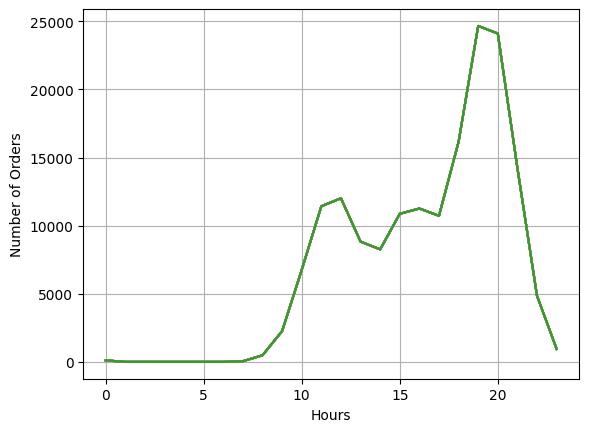

In [246]:
#5. Find the times during the day in which customers are more likely to order (i.e. quantity ordered by hour)

hours = [hour for hour, df in all_data.groupby('Hour')]
plt.plot(hours, all_data.groupby(['Hour']).count())
plt.xlabel('Hours')
plt.ylabel('Number of Orders')
plt.grid()
plt.show()

In [247]:
# 6. Find products that are most often sold together

# Find rows where order ID is duplicated
df = all_data[all_data['Order ID'].duplicated(keep=False)]

# Look at products: for each product (x) grouped by Order ID, join these products with a comma
df['Grouped'] = df.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))

# get rid of duplicates 
df = df[['Order ID', 'Grouped']].drop_duplicates()

from itertools import combinations
from collections import Counter

#  set up a counter()
count = Counter()

for row in df['Grouped']:
    row_list = row.split(',') # Get lists for the product pairs in each row
    count.update(Counter(combinations(row_list, 2))) # count each pair and put into dictionary

for key, value in count.most_common(20): # key is number of pair occurences, value is the product combination
    print(key, value)


('SlimLine Tubing for AirSense', ' AirCurve and  S9 CPAP Machines') 343
('AirMini - AutoSet Travel Portable CPAP Machine', 'Lofta Travel CPAP Disposable Air Filters for AirMini') 134
('AirSense 10 AutoSet Card-to-Cloud CPAP Machine', 'Lofta Disposable Filters for AirSense 10 and AirCurve 10') 125
('AirSense 11 AutoSet CPAP Machine', 'Filter Cover for AirSense 10') 124
('AirMini - AutoSet Travel Portable CPAP Machine', 'AirFit F20 Full Face CPAP Mask - Complete System with Airmini Setup Pack') 112
('Luna G3 BiLevel 25A CPAP Machine', 'Luna G3 Reusable Air Filter - 2 Pack') 102
('Breas Z2 Auto Travel CPAP Machine', 'Breas Slim Style Tube') 94
('AirSense 11 AutoSet CPAP Machine', 'AirFit N20 Nasal Cushion CPAP Mask Complete System') 92
('AirSense 10 AutoSet Card-to-Cloud CPAP Machine', 'AirFit N30i Nasal Cradle CPAP Mask - Complete Starter Kit') 90
('AirSense 10 AutoSet Card-to-Cloud CPAP Machine', 'AirCurve and AirSense 10 Slim Tubing by Lofta') 67
('Breas Z2 Auto Travel CPAP Machine', '

C:\Users\dusti\AppData\Local\Temp\ipykernel_28864\3162721886.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Grouped'] = df.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))


In [ ]:
# Sources
# scraping web data - https://www.youtube.com/watch?v=HiOtQMcI5wg&t=3s
# generationg mock data - https://www.youtube.com/watch?v=VJBY2eVtf7o
# analyzing data - https://www.youtube.com/watch?v=eMOA1pPVUc4&t=1814s 